In [1]:
from __future__ import print_function, division
%run ../basics.ipynb

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Loading BokehJS ...

Using Theano backend.


In [2]:
df = pd.read_csv('../data/learning_resources.csv')
display(df.head(2))
tags = pd.read_csv('../data/tags.csv')
display(tags.head(2))
df['tags'] = df['id'].apply(lambda x: (' '.join(tags[tags['id'] == x]['concept_tag'].values.tolist())).strip())
print(df.columns)
print(df.count())
df.head(2)

,id,title,subtitle,description,short_description,syllabus,url,slug,difficulty,created,...,available,end_date,typical_learning_time,rating,price,new,language,format,license,venue
0,cs101,Intro to Computer Science,Build a Search Engine & a Social Network,In this introduction to computer programming c...,Learn key computer science concepts in this in...,###Lesson 1: How to Get Started\n\n- Interview...,https://www.udacity.com/course/intro-to-comput...,intro-to-computer-science--cs101,beginner,NaN,...,NaN,NaN,3months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity
1,ud257,A/B Testing,Online Experiment Design and Analysis,This course will cover the design and analysis...,This course will cover the design and analysis...,### Lesson 1: Overview of A/B Testing\nThis le...,https://www.udacity.com/course/ab-testing--ud2...,ab-testing--ud257,intermediate,NaN,...,NaN,NaN,1months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity


,id,shortname,concept_tag,url
0,ud257,ab-testing--ud257,video_lecture,https://www.udacity.com/course/ab-testing--ud2...
1,ud257,ab-testing--ud257,in_depth,https://www.udacity.com/course/ab-testing--ud2...


Index([u'id', u'title', u'subtitle', u'description', u'short_description',
       u'syllabus', u'url', u'slug', u'difficulty', u'created',
       u'date_modified', u'date_published', u'available', u'end_date',
       u'typical_learning_time', u'rating', u'price', u'new', u'language',
       u'format', u'license', u'venue', u'tags'],
      dtype='object')
id                       458
title                    457
subtitle                 117
description              390
short_description         17
syllabus                  46
url                      458
slug                     458
difficulty               111
created                  206
date_modified              0
date_published           206
available                206
end_date                   0
typical_learning_time    202
rating                    81
price                    452
new                        0
language                 458
format                   458
license                  357
venue                    458
tags 

,id,title,subtitle,description,short_description,syllabus,url,slug,difficulty,created,...,end_date,typical_learning_time,rating,price,new,language,format,license,venue,tags
0,cs101,Intro to Computer Science,Build a Search Engine & a Social Network,In this introduction to computer programming c...,Learn key computer science concepts in this in...,###Lesson 1: How to Get Started\n\n- Interview...,https://www.udacity.com/course/intro-to-comput...,intro-to-computer-science--cs101,beginner,NaN,...,NaN,3months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity,video_lecture project overview computer_scienc...
1,ud257,A/B Testing,Online Experiment Design and Analysis,This course will cover the design and analysis...,This course will cover the design and analysis...,### Lesson 1: Overview of A/B Testing\nThis le...,https://www.udacity.com/course/ab-testing--ud2...,ab-testing--ud257,intermediate,NaN,...,NaN,1months,NaN,Free,NaN,en,MOOC,Creative Commons Attribution-NonCommercial- No...,Udacity,video_lecture in_depth project data_collection...


In [3]:
class NN(object):
    def __init__(self):
        self.nn = None
        
    def build_nn(self, X, y):
        nmf = Input(shape=(X.shape[1],), dtype='float32', name='nmf')
        d1 = Dense(500, activation='tanh')(nmf)
        d2 = Dense(500, activation='tanh')(d1)
        d3 = Dense(500, activation='tanh')(d2)
        out = Dense(y.shape[1], activation='sigmoid')(d3)
        model = Model(nmf, out)
        model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae'])
        print(model.summary())
        self.nn = model
        
    def fit(self, X, y):
        self.build_nn(X, y)
        hist = self.nn.fit(X, y,
              batch_size=1,
              shuffle=True,
              nb_epoch=500, 
              verbose=2)
        if 'val_loss' in hist.history:
            data = zip(hist.history['loss'], hist.history['val_loss'])
            hist_df = pd.DataFrame(columns=['train', 'val'], data=data)
            hist_df.plot(y=['train', 'val'], secondary_y=['val'])
            plt.show()
        else:
            data = hist.history['loss']
            hist_df = pd.DataFrame(columns=['train'], data=data)
            hist_df.plot(y=['train'])
            plt.show()
        
    def predict(self, X):
        # predict using nn
        return self.nn.predict(X)

In [4]:
class CLF(object):
    def __init__(self, n_topics=20):
        self.n_topics = n_topics
        self.vectorizer = TfidfVectorizer(stop_words='english', max_df=0.6, min_df=5, ngram_range=(1 ,3))
        self.tag_vectorizer = CountVectorizer(max_df=.3, min_df=.0)
        self.nmf = NMF(n_components=n_topics, random_state=2016)
        self.clf = None
        self.topic_dict = None

    def fit(self, X, y, viz=True):
        orig_X = X.copy()
        X = self.prepare_X(X)
        X = self.vectorize_X(X, fit=True, viz=viz)
        if viz:
            try:
                tsne_plot(X, orig_X[[orig_X.columns[0]]], fit=True)
            except:
                print(traceback.format_exc())
        y = self.vectorize_y(y, fit=True)
        self.clf = NN()
        filt = np.array(y.sum(axis=1) > 0).flatten() # don't train on untagged resources
        if sum(filt) != y.shape[0]:
            print('excluding untagged resources for clf training')
            print(y.shape)
            print(filt.shape)
            print(y.shape[0], end=' -> ')
            y = y[filt, :]
            X = X[filt, :]
            print(y.shape[0])
        self.clf.fit(X, y)
        
    def predict(self, X):
        X = self.prepare_X(X)
        X = self.vectorize_X(X, fit=False)
        return self.clf.predict(X)
    
    @staticmethod
    def prepare_X(X):
        if isinstance(X, pd.DataFrame):
            concat_x = pd.Series(index=X.index, data='')
            for i in X.columns:
                concat_x += ' ' + X[i].apply(text_cleanup)
            X = concat_x
        else:
            assert isinstance(X, pd.Series)
        return X
        
    def vectorize_X(self, X, fit=False, viz=False):
        if fit:
            tfidf = self.vectorizer.fit_transform(X.values)
        else:
            tfidf = self.vectorizer.transform(X.values)
        tfidf, words = filter_word_rep(tfidf, self.vectorizer.get_feature_names())
        print('tfidf shape', tfidf.shape)
        # tfidf = (tfidf > 0.).astype('float')
        
        if fit:
            nmf = self.nmf.fit_transform(tfidf)
            feature_names = words
            n_top_words = 50
            self.topic_dict = dict()
            for topic_idx, topic in enumerate(self.nmf.components_):
                topic_top_words = [feature_names[i]
                                for i in topic.argsort()[:-n_top_words - 1:-1]]
                topic_top_words_vals = sorted(topic.ravel(), reverse=True)[:n_top_words]
                text_freq = zip(topic_top_words, topic_top_words_vals)
                if viz:
                    print("v v v v \tTopic #%d\t" % topic_idx, end='v v v v v')
                    wordcloud(text_freq)
                topic_top_words = ", ".join(topic_top_words)
                #print(topic_top_words)
                self.topic_dict[topic_idx] = text_freq
            if viz:
                viz_nmf_output(nmf)
        else:
            nmf = self.nmf.transform(tfidf)
        print('nmf shape:', nmf.shape)
        return nmf
    
    def vectorize_y(self, y, fit=False):
        if fit:
            y = y.fillna(' ')
            y = self.tag_vectorizer.fit_transform(y.values)
            if self.tag_vectorizer.stop_words_:
                print('ignored tags:')
                pprint(self.tag_vectorizer.stop_words_)
            print('considered tags: (tag, resources tagged in %)')
            pprint(sorted(zip(self.tag_vectorizer.get_feature_names(), 
                              np.array(y.sum(axis=0)).flatten()/y.shape[0]*100), key=itemgetter(1), reverse=True))
        else:
            y = self.tag_vectorizer.transform(y.values)
        y = (y > 0).astype('float').todense()
        print('y shape', y.shape)
        return y
    
    def get_tag_names(self):
        return self.tag_vectorizer.get_feature_names()

# resources: 458
tagged resources: 356
tfidf shape (458, 2426)
v v v v 	Topic #0	v v v v v

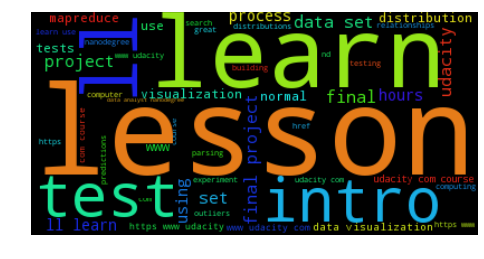

v v v v 	Topic #1	v v v v v

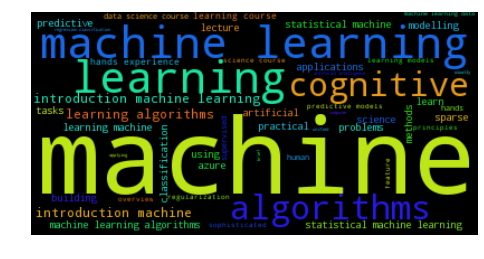

v v v v 	Topic #2	v v v v v

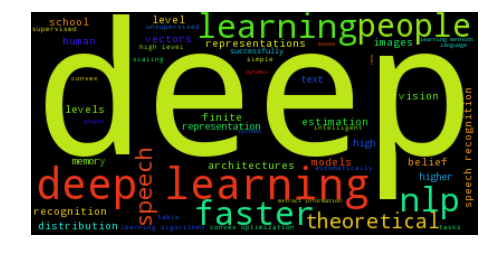

v v v v 	Topic #3	v v v v v

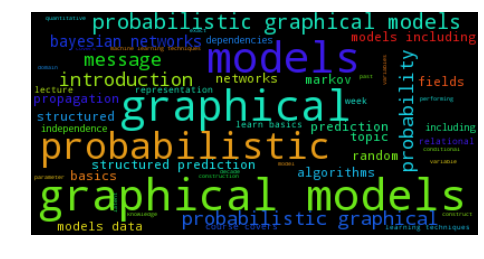

v v v v 	Topic #4	v v v v v

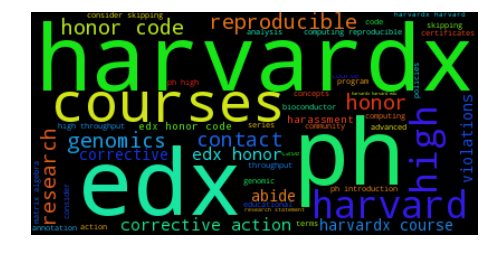

v v v v 	Topic #5	v v v v v

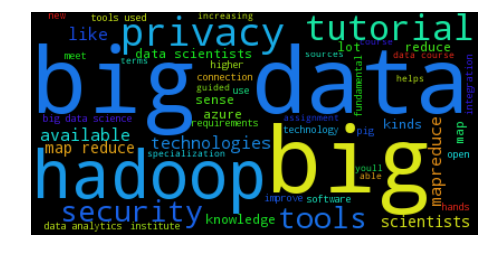

v v v v 	Topic #6	v v v v v

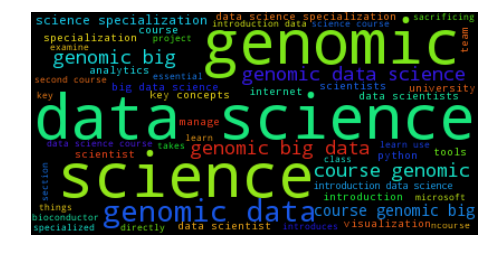

v v v v 	Topic #7	v v v v v

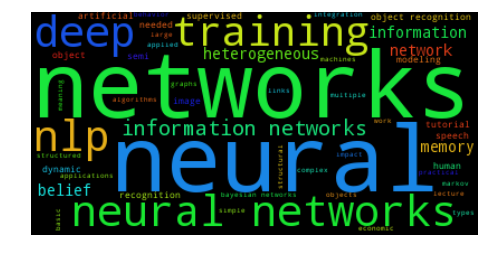

v v v v 	Topic #8	v v v v v

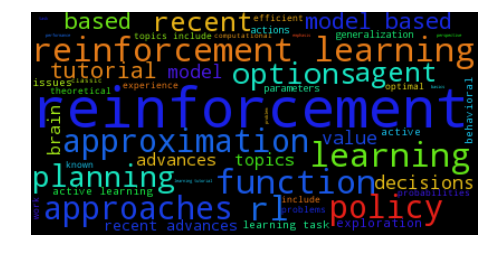

v v v v 	Topic #9	v v v v v

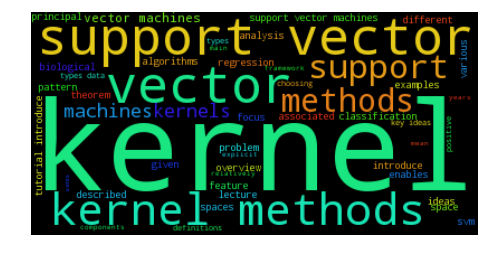

v v v v 	Topic #10	v v v v v

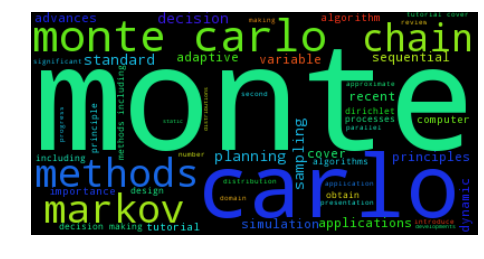

v v v v 	Topic #11	v v v v v

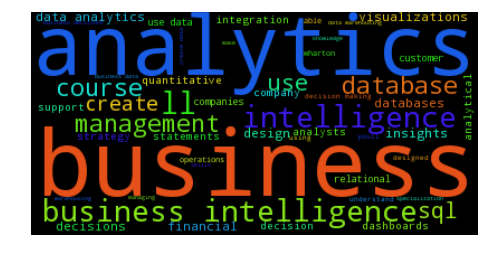

v v v v 	Topic #12	v v v v v

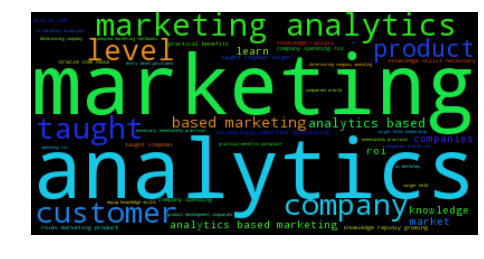

v v v v 	Topic #13	v v v v v

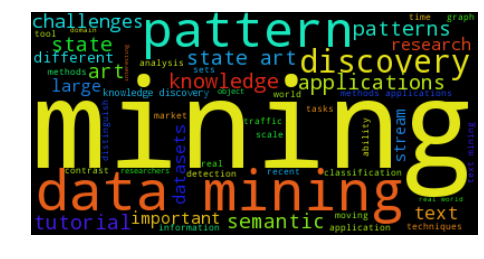

v v v v 	Topic #14	v v v v v

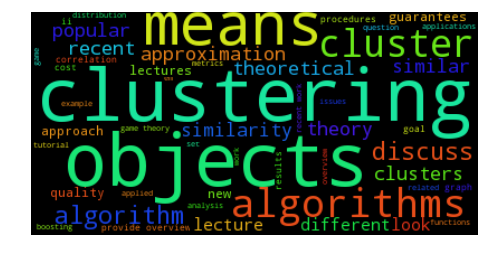

v v v v 	Topic #15	v v v v v

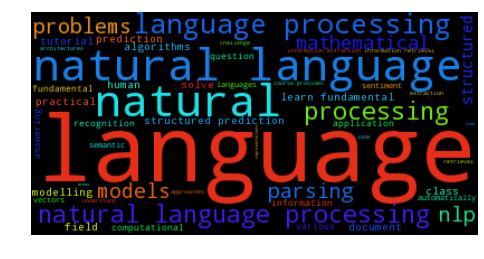

v v v v 	Topic #16	v v v v v

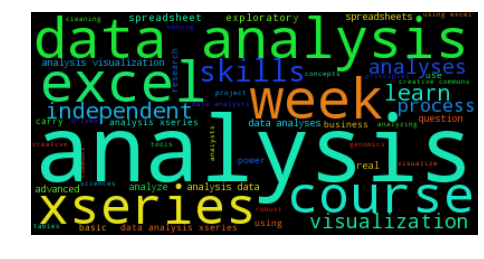

v v v v 	Topic #17	v v v v v

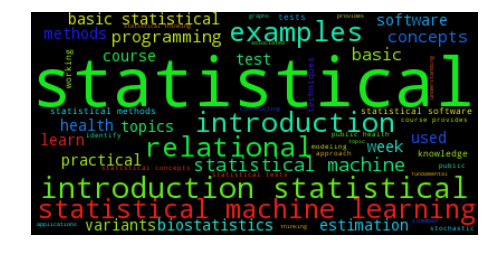

v v v v 	Topic #18	v v v v v

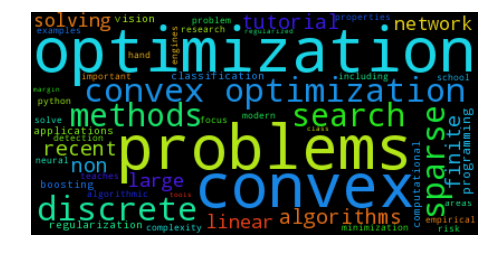

v v v v 	Topic #19	v v v v v

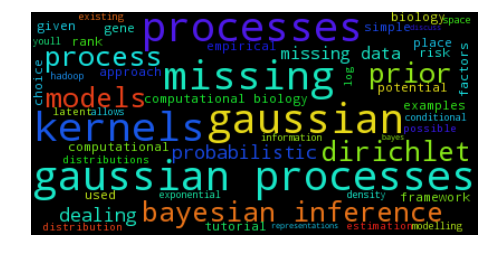

v v v v 	Topic #20	v v v v v

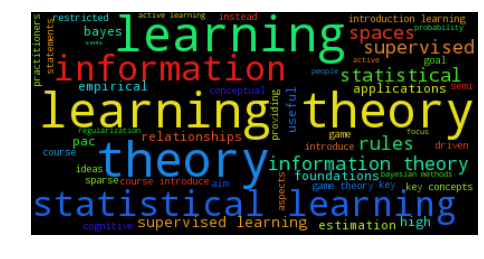

v v v v 	Topic #21	v v v v v

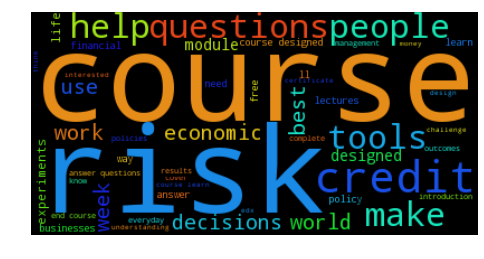

v v v v 	Topic #22	v v v v v

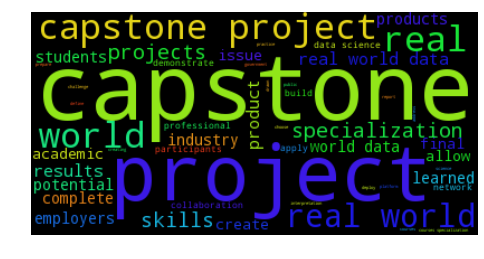

v v v v 	Topic #23	v v v v v

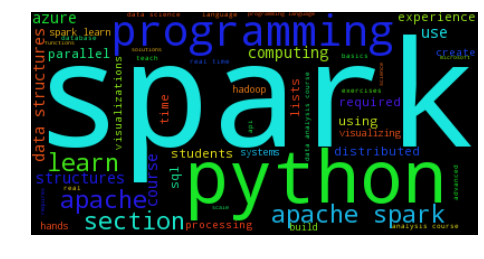

v v v v 	Topic #24	v v v v v

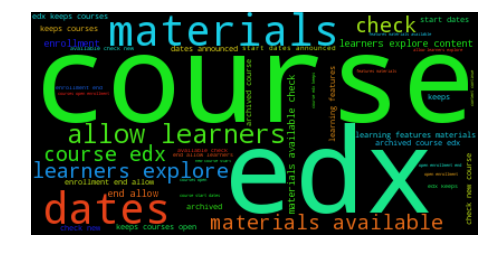

v v v v 	Topic #25	v v v v v

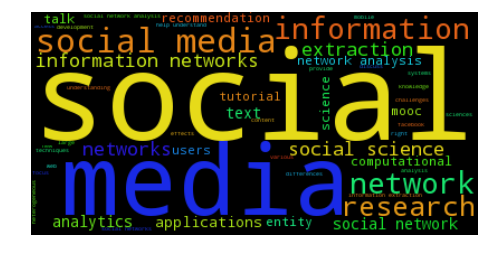

v v v v 	Topic #26	v v v v v

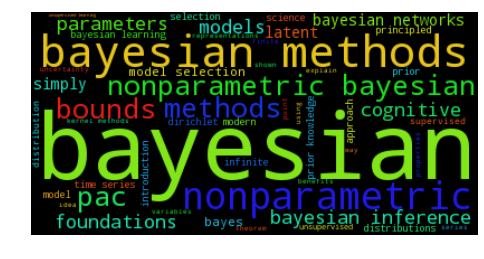

v v v v 	Topic #27	v v v v v

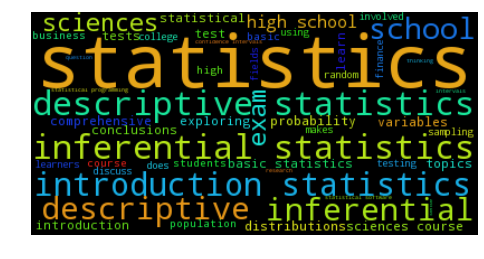

v v v v 	Topic #28	v v v v v

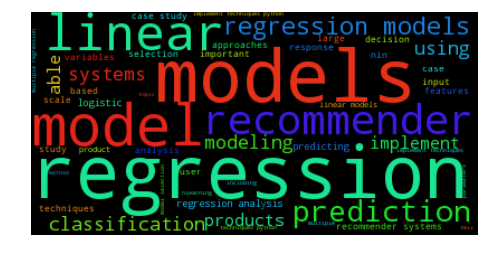

v v v v 	Topic #29	v v v v v

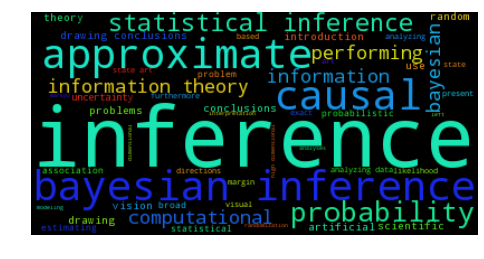

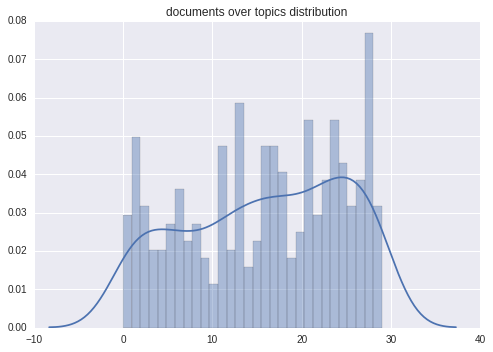

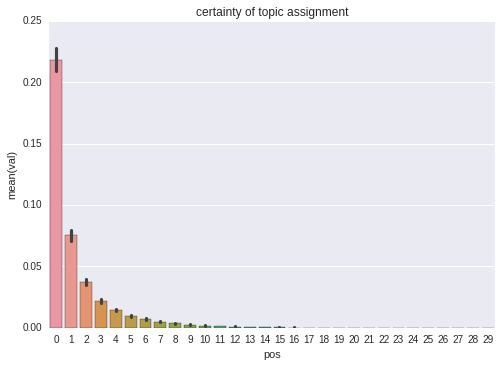

nmf shape: (458, 30)
458


ignored tags:
set([u'mooc', u'video_lecture'])
considered tags: (tag, resources tagged in %)
[(u'machine_learning', 28.820960698689959),
 (u'in_depth', 18.5589519650655),
 (u'unsupervised_learning', 11.790393013100436),
 (u'probability_statistics', 11.572052401746726),
 (u'overview', 10.698689956331878),
 (u'project', 9.8253275109170293),
 (u'reinforcement_learning', 8.7336244541484707),
 (u'business_analytics', 7.4235807860262017),
 (u'neural_networks', 6.9868995633187767),
 (u'data_visualization', 5.4585152838427948),
 (u'big_data', 4.5851528384279483),
 (u'python', 4.5851528384279483),
 (u'data_collection', 3.4934497816593884),
 (u'graph_analytics', 3.2751091703056767),
 (u'project_focused', 3.2751091703056767),
 (u'data_integration', 3.0567685589519651),
 (u'case_study', 2.8384279475982535),
 (u'hadoop', 2.6200873362445414),
 (u'kernel_methods', 2.4017467248908297),
 (u'healthcare', 2.1834061135371177),
 (u'high_performance_computing', 2.1834061135371177),
 (u'natural_language_proc

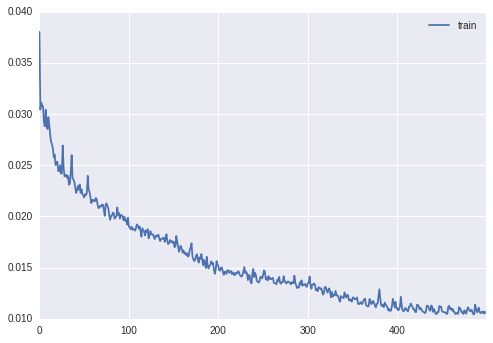

In [5]:
clf = CLF(n_topics=30)
print('# resources:', len(df))
print('tagged resources:', (df['tags'].apply(len) > 0).sum())
clf.fit(df[['title', 'subtitle', 'description', 'syllabus']], df['tags'], viz=True)

In [6]:
y_pred = clf.predict(df[['title', 'subtitle', 'description', 'syllabus']])

tfidf shape (458, 2426)
nmf shape: (458, 30)


In [11]:
pos_th = 0.5
neg_th = 0.1
tags_rec = True
tags_rev = False
recs = list()
revs = list()
y_pred = y_pred
y_true = clf.vectorize_y(df['tags'])
tags = np.array(clf.get_tag_names())
for idx, title in enumerate(df['title']):
    y_pred_row = np.array(y_pred[idx, :]).flatten()
    y_true_row = np.array(y_true[idx, :]).flatten()
    recommended_tags = (y_pred_row >= pos_th) & (y_true_row < 0.5)
    recommended_tags = zip(tags[recommended_tags], y_pred_row[recommended_tags])
    
    revise_tags = (y_pred_row <= neg_th) & (y_true_row > 0.5)
    revise_tags = zip(tags[revise_tags], y_pred_row[revise_tags])
    
    if (len(recommended_tags) > 0 and tags_rec) or (len(revise_tags) > 0 and tags_rev):
        print(title)
        df_entry = df.iloc[idx]
        c_id, c_url = df_entry['id'], df_entry['url']
        print(c_id, c_url)
        if len(recommended_tags) > 0 and tags_rec:
            print('  recommended tags:')
            for i, p in sorted(recommended_tags, key=itemgetter(1), reverse=True):
                print('\t', i, '(%.2f' % (p * 100), '% )')
                recs.append((c_id, i, p * 100))
        if len(revise_tags) > 0 and tags_rev:
            print('  revise tags:')
            for i, p in sorted(revise_tags, key=itemgetter(1)):
                print('\t', i, '(%.2f' % ((1. - p) * 100), '% )')
                revs.append((c_id, i, (1. - p) * 100))
        print('-' * 80)

y shape (458, 73)
Text Mining and Analytics
v1-2301 http://www.coursera.org/course/textanalytics
  recommended tags:
	 machine_learning (99.95 % )
--------------------------------------------------------------------------------
Pattern Discovery in Data Mining
v1-2298 http://www.coursera.org/course/patterndiscovery
  recommended tags:
	 machine_learning (99.95 % )
--------------------------------------------------------------------------------
Capstone: Geospatial Analysis
MXcK-3EiEeWbbw5cIAKQrw http://www.coursera.org/learn/gis-capstone
  recommended tags:
	 data_visualization (89.70 % )
--------------------------------------------------------------------------------
Data Science Capstone
2y_2_3REEeWKsgrp3VnvAw http://www.coursera.org/learn/data-science-project
  recommended tags:
	 data_visualization (89.70 % )
--------------------------------------------------------------------------------
Introduction to Recommender Systems
v1-746 http://www.coursera.org/course/recsys
  recommended

In [9]:
rec_df = pd.DataFrame(columns=['id', 'tag', 'probability'], data=recs)
rec_df.to_csv('tag_recommendations.csv', encoding='utf-8', index=False, quoting=QUOTE_ALL)